# SARIMA Time Series Forecasting on Daily Sales Data

This notebook demonstrates how to use **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** 
for **time series forecasting** on a daily sales dataset.




## 1. Import Libraries
We begin by importing the required Python libraries for data manipulation, visualization, 
and time series modeling.


In [11]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
import seaborn as sns


## 2. Load and Inspect Data
We load the dataset `salesdaily.csv`, parse the `datum` column as a date, 
and set it as the time index.


In [12]:
daily_df = pd.read_csv(r'C:\Users\aravi\npn\SARIMA\salesdaily.csv')

# Convert to datetime
daily_df['datum'] = pd.to_datetime(daily_df['datum'], dayfirst=True, errors='coerce')

# Copy into df and extract time components
df = daily_df
df['year'] = df['datum'].dt.year
df['month'] = df['datum'].dt.month
df['day'] = df['datum'].dt.day

# Set datetime index
df.set_index(df['datum'], inplace=True)

# Select columns for forecasting
columns = df.columns[1:9]
columns


Index(['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06'], dtype='object')

## 3. Train-Test-Predict Split
- **Train**: first 60% of data  
- **Test**: next 30% of data  
- **Predict**: last 10% of data (for future unseen values)


In [13]:
total_rows = len(df)
train_size = int(total_rows * 0.60)
test_size = int(total_rows * 0.90)

train = df[:train_size]
test = df[train_size:test_size]
predict = df[test_size:]


## 4. Define SARIMA Pipeline
We build reusable functions to:


- **Training**: Auto-tunes `(p,d,q)` and seasonal `(P,D,Q,m)` using grid search → selects best model via **AIC**.  
- **Testing**: Predicts on test set, aligns data, removes NaNs → evaluates with **R², MSE, RMSE, MAPE**.  
- **Forecasting**: Uses best model to generate **future predictions** (N steps ahead).  
 


In [16]:
# 🔹 Training function with auto-tuning
def train_sarima_model(ftraindata, column, seasonal_period=7):
    print(f"\n🔎 Tuning SARIMA model for {column} with {len(ftraindata)} data points...")
    warnings.filterwarnings("ignore")

    # Candidate parameter ranges
    p = d = q = range(0, 2)   # ARIMA terms
    P = D = Q = range(0, 2)   # Seasonal terms
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in itertools.product(P, D, Q)]

    best_aic = float("inf")
    best_model = None
    best_params = None

    # Grid search
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(ftraindata,
                                order=param,
                                seasonal_order=seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_model = results
                    best_params = (param, seasonal_param)
            except:
                continue

    print(f"✅ Best params for {column}: order={best_params[0]}, seasonal_order={best_params[1]} (AIC={best_aic:.2f})")
    return best_model


# 🔹 Testing function
def test_sarima_model(results, ftestdata, column):
    predictions = results.predict(start=ftestdata.index[0], end=ftestdata.index[-1])

    # Align
    ftestdata, predictions = ftestdata.align(predictions, join='inner')

    # Drop NaNs
    mask = (~ftestdata.isna()) & (~predictions.isna())
    ftestdata = ftestdata[mask]
    predictions = predictions[mask]

    if len(ftestdata) == 0:
        print(f"⚠️ No valid test data for {column} after NaN removal.")
        return predictions, np.nan, np.nan, np.nan

    # Metrics
    r_squared = r2_score(ftestdata, predictions)
    mse = np.mean((ftestdata - predictions) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ftestdata - predictions) / ftestdata.replace(0, np.nan))) * 100

    print(f"📊 Evaluation for {column}: R²={r_squared:.3f}, RMSE={rmse:.3f}, MAPE={mape:.2f}%")
    return predictions, r_squared, mse, mape


# 🔹 Future prediction function
def predict_future(results, steps, column):
    future_predictions = results.get_forecast(steps=steps)
    forecast_values = future_predictions.predicted_mean
    print(f"🔮 Future predictions for {column} ({steps} steps ahead): \n{forecast_values}")
    return forecast_values


## 5. Train, Test, and Forecast for Each Column
We loop through each column in the dataset, train SARIMA, 
evaluate results, plot actual vs predicted values, 
and forecast future steps.



🔎 Tuning SARIMA model for M01AB with 1435 data points...
✅ Best params for M01AB: order=(0, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=2371.27)
📊 Evaluation for M01AB: R²=-0.123, RMSE=3.151, MAPE=98.13%


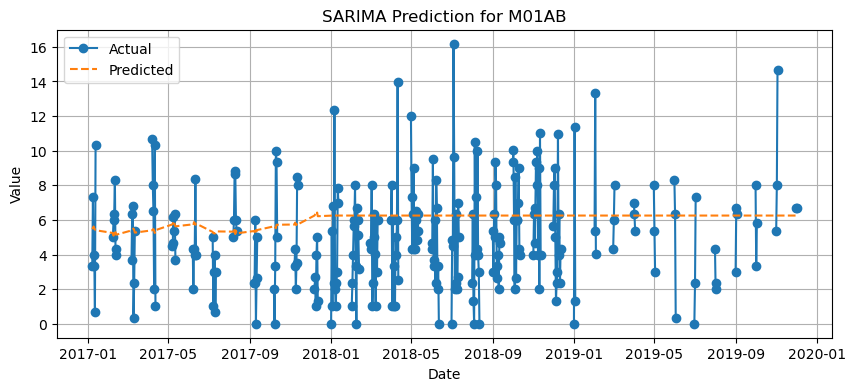

🔮 Future predictions for M01AB (30 steps ahead): 
2017-12-07    6.250428
2017-12-08    6.314383
2017-12-09    6.365349
2017-12-10    6.294396
2017-12-11    6.426199
2017-12-12    6.212124
2017-12-13    6.192242
2017-12-14    6.250662
2017-12-15    6.250662
2017-12-16    6.250662
2017-12-17    6.250662
2017-12-18    6.250662
2017-12-19    6.250662
2017-12-20    6.250662
2017-12-21    6.250662
2017-12-22    6.250662
2017-12-23    6.250662
2017-12-24    6.250662
2017-12-25    6.250662
2017-12-26    6.250662
2017-12-27    6.250662
2017-12-28    6.250662
2017-12-29    6.250662
2017-12-30    6.250662
2017-12-31    6.250662
2018-01-01    6.250662
2018-01-02    6.250662
2018-01-03    6.250662
2018-01-04    6.250662
2018-01-05    6.250662
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for M01AE with 1435 data points...
✅ Best params for M01AE: order=(0, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=2178.48)
📊 Evaluation for M01AE: R²=-0.050, RMSE=2.291, MAPE=123.02%


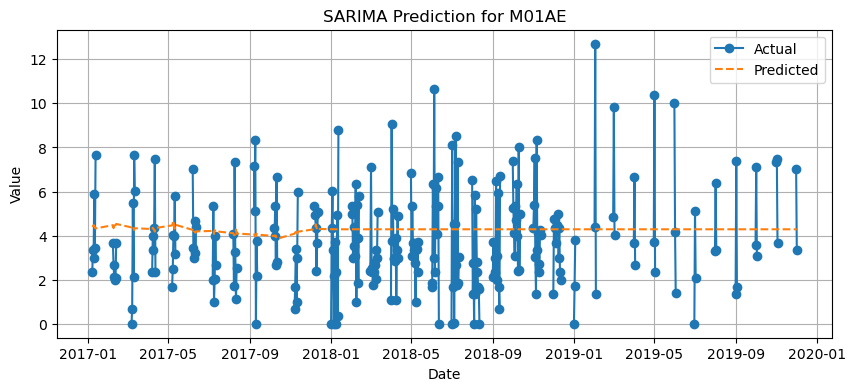

🔮 Future predictions for M01AE (30 steps ahead): 
2017-12-07    4.285447
2017-12-08    4.317680
2017-12-09    4.510968
2017-12-10    4.381715
2017-12-11    4.251403
2017-12-12    4.300242
2017-12-13    4.252107
2017-12-14    4.285494
2017-12-15    4.285494
2017-12-16    4.285494
2017-12-17    4.285494
2017-12-18    4.285494
2017-12-19    4.285494
2017-12-20    4.285494
2017-12-21    4.285494
2017-12-22    4.285494
2017-12-23    4.285494
2017-12-24    4.285494
2017-12-25    4.285494
2017-12-26    4.285494
2017-12-27    4.285494
2017-12-28    4.285494
2017-12-29    4.285494
2017-12-30    4.285494
2017-12-31    4.285494
2018-01-01    4.285494
2018-01-02    4.285494
2018-01-03    4.285494
2018-01-04    4.285494
2018-01-05    4.285494
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for N02BA with 1435 data points...
✅ Best params for N02BA: order=(1, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=2338.75)
📊 Evaluation for N02BA: R²=-0.281, RMSE=2.455, MAPE=132.26%


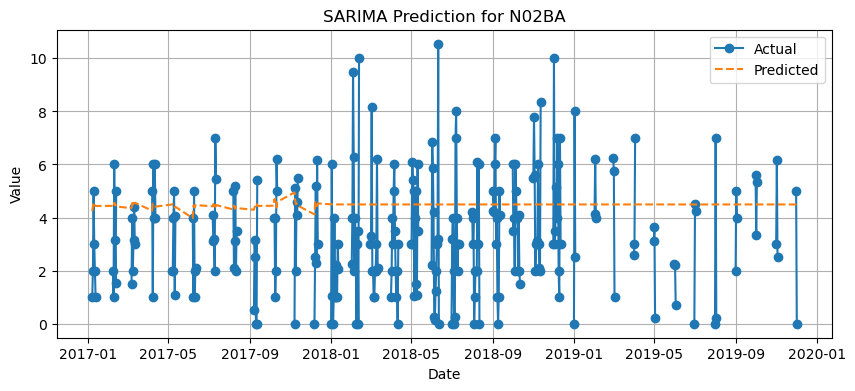

🔮 Future predictions for N02BA (30 steps ahead): 
2017-12-07    4.119623
2017-12-08    4.563198
2017-12-09    4.576284
2017-12-10    4.428051
2017-12-11    4.464000
2017-12-12    4.533700
2017-12-13    4.402255
2017-12-14    4.483961
2017-12-15    4.493005
2017-12-16    4.494006
2017-12-17    4.494116
2017-12-18    4.494129
2017-12-19    4.494130
2017-12-20    4.494130
2017-12-21    4.494130
2017-12-22    4.494130
2017-12-23    4.494130
2017-12-24    4.494130
2017-12-25    4.494130
2017-12-26    4.494130
2017-12-27    4.494130
2017-12-28    4.494130
2017-12-29    4.494130
2017-12-30    4.494130
2017-12-31    4.494130
2018-01-01    4.494130
2018-01-02    4.494130
2018-01-03    4.494130
2018-01-04    4.494130
2018-01-05    4.494130
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for N02BE with 1435 data points...
✅ Best params for N02BE: order=(1, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=4114.51)
📊 Evaluation for N02BE: R²=-0.053, RMSE=15.918, MAPE=47.53%


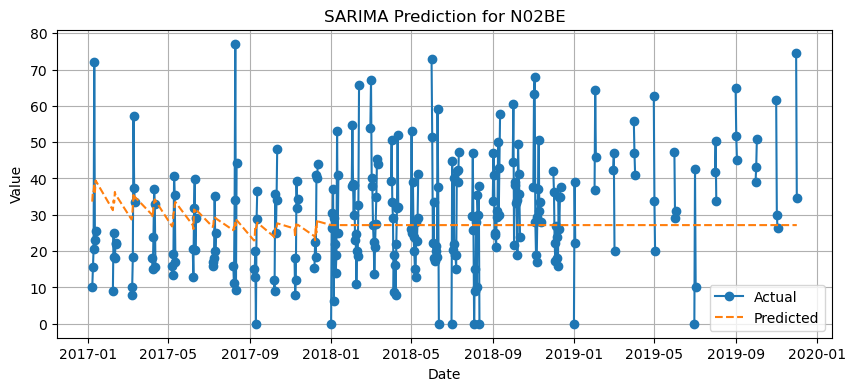

🔮 Future predictions for N02BE (30 steps ahead): 
2017-12-07    24.083062
2017-12-08    22.985151
2017-12-09    27.057384
2017-12-10    25.129646
2017-12-11    28.714849
2017-12-12    28.193409
2017-12-13    28.454711
2017-12-14    27.388960
2017-12-15    27.198415
2017-12-16    27.164347
2017-12-17    27.158256
2017-12-18    27.157167
2017-12-19    27.156973
2017-12-20    27.156938
2017-12-21    27.156932
2017-12-22    27.156931
2017-12-23    27.156930
2017-12-24    27.156930
2017-12-25    27.156930
2017-12-26    27.156930
2017-12-27    27.156930
2017-12-28    27.156930
2017-12-29    27.156930
2017-12-30    27.156930
2017-12-31    27.156930
2018-01-01    27.156930
2018-01-02    27.156930
2018-01-03    27.156930
2018-01-04    27.156930
2018-01-05    27.156930
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for N05B with 1435 data points...
✅ Best params for N05B: order=(0, 1, 1), seasonal_order=(1, 0, 1, 7) (AIC=3228.80)
📊 Evaluation for N05B: R²=-0.169, RMSE=5.783

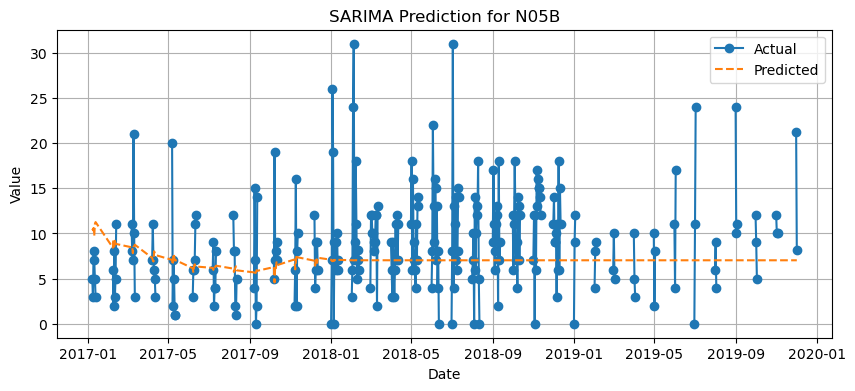

🔮 Future predictions for N05B (30 steps ahead): 
2017-12-07    6.977030
2017-12-08    6.431772
2017-12-09    7.323509
2017-12-10    7.143521
2017-12-11    6.741340
2017-12-12    7.302936
2017-12-13    7.471926
2017-12-14    7.052316
2017-12-15    7.383723
2017-12-16    6.841726
2017-12-17    6.951123
2017-12-18    7.195568
2017-12-19    6.854230
2017-12-20    6.751519
2017-12-21    7.006557
2017-12-22    6.805128
2017-12-23    7.134553
2017-12-24    7.068062
2017-12-25    6.919489
2017-12-26    7.126953
2017-12-27    7.189381
2017-12-28    7.034369
2017-12-29    7.156797
2017-12-30    6.956573
2017-12-31    6.996986
2018-01-01    7.087289
2018-01-02    6.961193
2018-01-03    6.923249
2018-01-04    7.017465
2018-01-05    6.943053
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for N05C with 1435 data points...
✅ Best params for N05C: order=(0, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=1469.01)
📊 Evaluation for N05C: R²=-0.011, RMSE=1.244, MAPE=47.69%


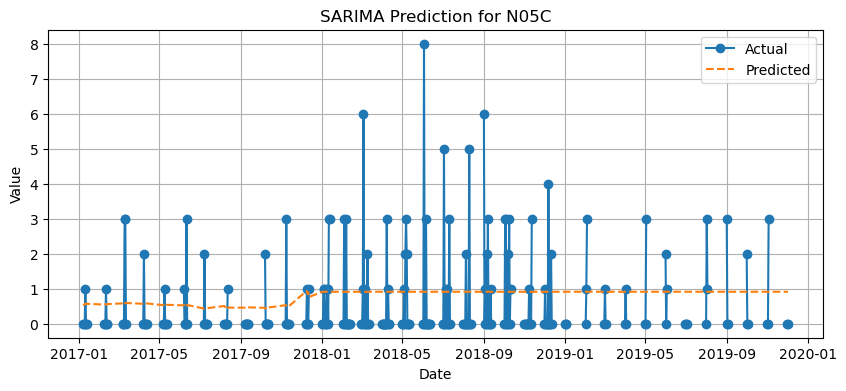

🔮 Future predictions for N05C (30 steps ahead): 
2017-12-07    0.913624
2017-12-08    0.907123
2017-12-09    0.930594
2017-12-10    0.855482
2017-12-11    0.893037
2017-12-12    0.761591
2017-12-13    0.930591
2017-12-14    0.913435
2017-12-15    0.913435
2017-12-16    0.913435
2017-12-17    0.913435
2017-12-18    0.913435
2017-12-19    0.913435
2017-12-20    0.913435
2017-12-21    0.913435
2017-12-22    0.913435
2017-12-23    0.913435
2017-12-24    0.913435
2017-12-25    0.913435
2017-12-26    0.913435
2017-12-27    0.913435
2017-12-28    0.913435
2017-12-29    0.913435
2017-12-30    0.913435
2017-12-31    0.913435
2018-01-01    0.913435
2018-01-02    0.913435
2018-01-03    0.913435
2018-01-04    0.913435
2018-01-05    0.913435
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for R03 with 1435 data points...
✅ Best params for R03: order=(0, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=3063.30)
📊 Evaluation for R03: R²=-0.030, RMSE=7.048, MAPE=112.07%


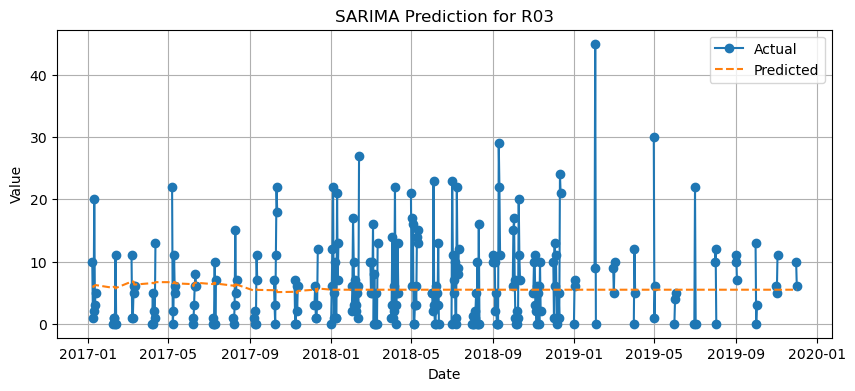

🔮 Future predictions for R03 (30 steps ahead): 
2017-12-07    5.465806
2017-12-08    5.496977
2017-12-09    5.589067
2017-12-10    5.125631
2017-12-11    5.303872
2017-12-12    5.660358
2017-12-13    5.196922
2017-12-14    5.465504
2017-12-15    5.465504
2017-12-16    5.465504
2017-12-17    5.465504
2017-12-18    5.465504
2017-12-19    5.465504
2017-12-20    5.465504
2017-12-21    5.465504
2017-12-22    5.465504
2017-12-23    5.465504
2017-12-24    5.465504
2017-12-25    5.465504
2017-12-26    5.465504
2017-12-27    5.465504
2017-12-28    5.465504
2017-12-29    5.465504
2017-12-30    5.465504
2017-12-31    5.465504
2018-01-01    5.465504
2018-01-02    5.465504
2018-01-03    5.465504
2018-01-04    5.465504
2018-01-05    5.465504
Freq: D, Name: predicted_mean, dtype: float64

🔎 Tuning SARIMA model for R06 with 1435 data points...
✅ Best params for R06: order=(1, 1, 1), seasonal_order=(0, 0, 1, 7) (AIC=2227.23)
📊 Evaluation for R06: R²=-0.016, RMSE=2.610, MAPE=99.19%


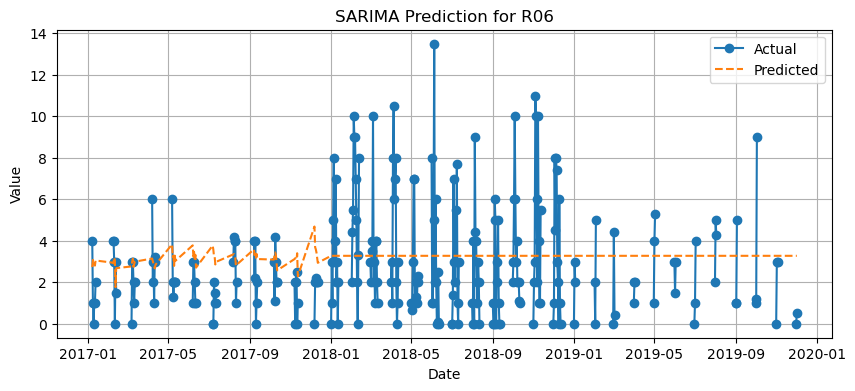

🔮 Future predictions for R06 (30 steps ahead): 
2017-12-07    4.686412
2017-12-08    3.688456
2017-12-09    3.589766
2017-12-10    3.437289
2017-12-11    3.185194
2017-12-12    2.936990
2017-12-13    2.194708
2017-12-14    3.103161
2017-12-15    3.247008
2017-12-16    3.269785
2017-12-17    3.273391
2017-12-18    3.273963
2017-12-19    3.274053
2017-12-20    3.274067
2017-12-21    3.274070
2017-12-22    3.274070
2017-12-23    3.274070
2017-12-24    3.274070
2017-12-25    3.274070
2017-12-26    3.274070
2017-12-27    3.274070
2017-12-28    3.274070
2017-12-29    3.274070
2017-12-30    3.274070
2017-12-31    3.274070
2018-01-01    3.274070
2018-01-02    3.274070
2018-01-03    3.274070
2018-01-04    3.274070
2018-01-05    3.274070
Freq: D, Name: predicted_mean, dtype: float64

Model Performance Summary:
  Column        R2         MSE        MAPE
0  M01AB -0.123221    9.930128   98.133428
1  M01AE -0.049858    5.249675  123.016304
2  N02BA -0.280524    6.028337  132.260972
3  N02BE -0.0533

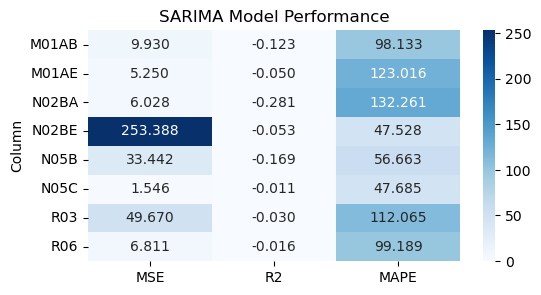

In [17]:
results_summary = []

for column in columns:
    ftraindata = train[column].resample('D').mean()
    ftestdata = test[column].resample('D').mean()
    
    # Train model
    results = train_sarima_model(ftraindata, column)
    
    # Test model
    predictions, r_squared, mse, mape = test_sarima_model(results, ftestdata, column)
    
    # Save results
    results_summary.append({
        "Column": column,
        "R2": r_squared,
        "MSE": mse,
        "MAPE": mape
    })
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(ftestdata.index, ftestdata, label="Actual", marker='o')
    plt.plot(predictions.index, predictions, label="Predicted", linestyle='--')
    plt.title(f"SARIMA Prediction for {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Forecast future values
    future_predictions = predict_future(results, steps=30, column=column)

# Convert to DataFrame
results_df = pd.DataFrame(results_summary)
print("\nModel Performance Summary:")
print(results_df)

# Heatmap visualization
plt.figure(figsize=(6, 3))
sns.heatmap(results_df.set_index("Column")[["MSE", "R2", "MAPE"]], annot=True, fmt=".3f", cmap="Blues")
plt.title("SARIMA Model Performance")
plt.show()